In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

import numpy as np
from imageio import imread

from skimage.transform import resize
from keras.layers import Dense 
from keras import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

## MobileNetV2

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [3]:
model_mobileNetV2 = MobileNetV2(

    include_top=False,  # Indicates that the top layer (fully connected layers) should not be included
    weights="imagenet",  # Use pre-trained weights from ImageNet
    input_shape=(224, 224, 3)
    )  

# Set the MobileNetV2 model to be non-trainable

model_mobileNetV2.trainable = False

In [4]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  
        layers.RandomRotation(0.1),
    ]
)

# Adjust the layer from which you extract the output for MobileNetV2
# This might need to be changed depending on the specific architecture of model.
x = model_mobileNetV2.layers[-6].output

# Create the new output layer
output = Dense(2, activation='softmax')(x)

# Create the new model with the custom output layer
model = Model(inputs=model_mobileNetV2.input, outputs=output)

# Freeze the layers except the last 5 to prevent updating their weights during training
for layer in model.layers[:-5]:
    layer.trainable = False

# Define new inputs for the final model
inputs = keras.Input(shape=(224, 224, 3))

# Apply data augmentation to the inputs
x = data_augmentation(inputs)

# Add a rescaling layer to scale input images to the range [-1, 1]
# This is important because MobileNetV2 expects inputs in this range.
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# Apply the MobileNetV2 model as a feature extractor
x = model_mobileNetV2(x, training=False)

x = GlobalAveragePooling2D()(x) 
x = Dropout(0.2)(x)  
outputs = Dense(1, activation='sigmoid')(x) 

# Define the final model with the newly added layers
model_final = keras.Model(inputs, outputs)


In [12]:
model_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0   

## Definition of optimization algorithms

In [5]:

def create_optimizer(name, learning_rate, momentum=0.0, rho=0.9, beta_1=0.9, beta_2=0.999):

    # Create and return an optimizer object from TensorFlow's keras.optimizers library.
    
    # :param name: A string representing the name of the optimizer.
    # :param learning_rate: A float representing the learning rate for the optimizer.
    # :param momentum: (Optional) A float representing the momentum for certain optimizers (default is 0.0).
    # :param rho: (Optional) A float representing the decay rate for the RMSprop optimizer (default is 0.9).
    # :param beta_1: (Optional) A float representing the exponential decay rate for the 1st moment estimates in Adam optimizer (default is 0.9).
    # :param beta_2: (Optional) A float representing the exponential decay rate for the 2nd moment estimates in Adam optimizer (default is 0.999).
    # :return: A TensorFlow optimizer object based on the specified name.
    # :raises ValueError: If the optimizer name is unknown.


    if name == 'gd': # Gradient Descent
        return tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif name == 'sgd': # Stochastic Gradient Descent
        return tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
    elif name == 'momentum': # Momentum
        return tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
    elif name == 'adagrad': # AdaGrad
        return tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif name == 'rmsprop': # RMSprop
        return tf.keras.optimizers.RMSprop(learning_rate=learning_rate, rho=rho)
    elif name == 'adam': # Adam
        return tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2)
    else:
        raise ValueError(f"Unknown optimizer name: {name}")




## Datasets




In [6]:
# Here we define a dictionary that can be used to map the folder name of the data of specific classes to the desired labels
class_dictionary_I = {0:"gas_station", 1:	"golf_ball"}
def decode_predictions(array, class_dictionary_I):
    return np.array(list(map(class_dictionary_I.get, array)))

class_dictionary_E = {0:"zebra", 1:	"Uszatek"}
def decode_predictions(array, class_dictionary_E):
    return np.array(list(map(class_dictionary_E.get, array)))


In [7]:
class_dictionary_I.values()

dict_values(['gas_station', 'golf_ball'])

In [8]:
class_dictionary_E.values()

dict_values(['zebra', 'Uszatek'])

In [9]:
# Specify the image size and batch size
image_size = (224, 224)
batch_size = 32

In [10]:
# Define the paths for the datasets
# Paths for the ImageNette dataset (a subset of ImageNet)
path_train_ds_I = "Imagenette/train"  # Path to the training dataset of Imagenette
path_test_ds_I = "Imagenette/test"  # Path to the testing dataset of Imagenette
path_val_ds_I = "Imagenette/val"  # Path to the validation dataset of Imagenette

# Paths for the ToyVision dataset (a custom dataset created for specific training and testing purposes)
path_train_ds_E = "data/train"  # Path to the training dataset of ToyVision
path_test_ds_E = "data/test"  # Path to the testing dataset of ToyVision
val_test_ds_E = "data/val"  # Path to the validation dataset of ToyVision


In [11]:

# Ładowanie danych dla zbioru Imagenette
train_ds_I = tf.keras.utils.image_dataset_from_directory(
    path_train_ds_I,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)




test_ds_I  = tf.keras.utils.image_dataset_from_directory(
    path_test_ds_I,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'

)

val_ds_I  = tf.keras.utils.image_dataset_from_directory(
    path_val_ds_I,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'

)

# Przetwarzanie danych - zmiana rozmiaru obrazów
train_ds_I = train_ds_I.map(lambda x, y: (tf.image.resize(x, image_size), y))
test_ds_I = test_ds_I.map(lambda x, y: (tf.image.resize(x, image_size), y))
val_ds_I = val_ds_I.map(lambda x, y: (tf.image.resize(x, image_size), y))

# Ładowanie danych ze zbioru Edutoyz
train_ds_E = tf.keras.utils.image_dataset_from_directory(
    path_train_ds_E,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'
)


test_ds_E  = tf.keras.utils.image_dataset_from_directory(
    path_test_ds_E,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'

)

val_ds_E  = tf.keras.utils.image_dataset_from_directory(
    path_test_ds_E,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='int'

)

# Przetwarzanie danych - zmiana rozmiaru obrazów
train_ds_E = train_ds_E.map(lambda x, y: (tf.image.resize(x, image_size), y))
test_ds_E = test_ds_E.map(lambda x, y: (tf.image.resize(x, image_size), y))
val_ds_E = test_ds_E.map(lambda x, y: (tf.image.resize(x, image_size), y))

Found 24 files belonging to 2 classes.
Found 2648 files belonging to 2 classes.
Found 24 files belonging to 2 classes.
Found 24 files belonging to 2 classes.
Found 552 files belonging to 2 classes.
Found 552 files belonging to 2 classes.


# Visualization of objects from the ImageNette dataset

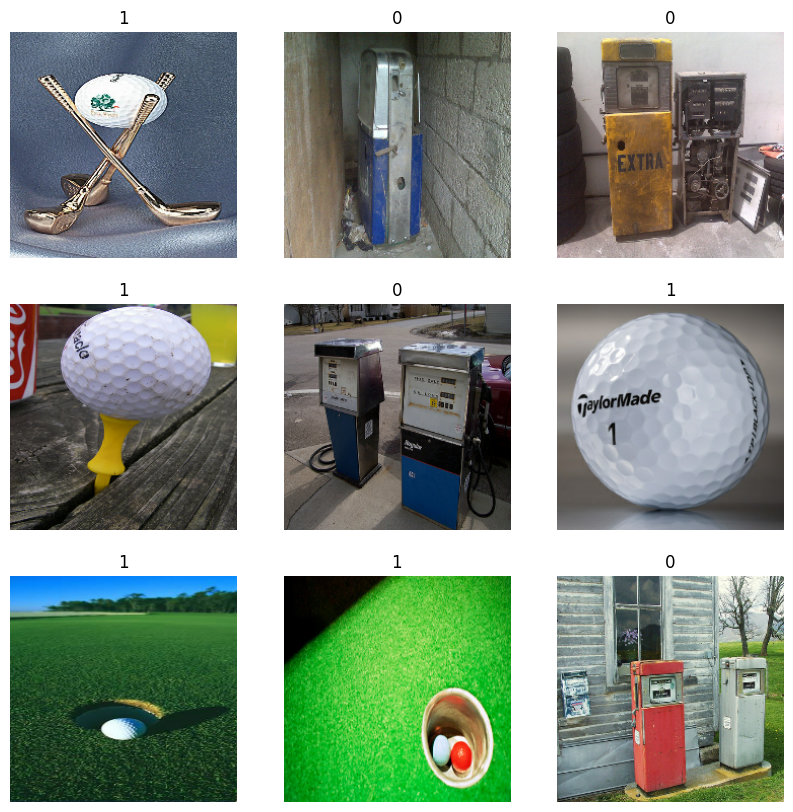

In [11]:
for images, labels in test_ds_I.take(1): 
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy()) 
        plt.axis("off")

# Visualization of objects from the ToyVision dataset

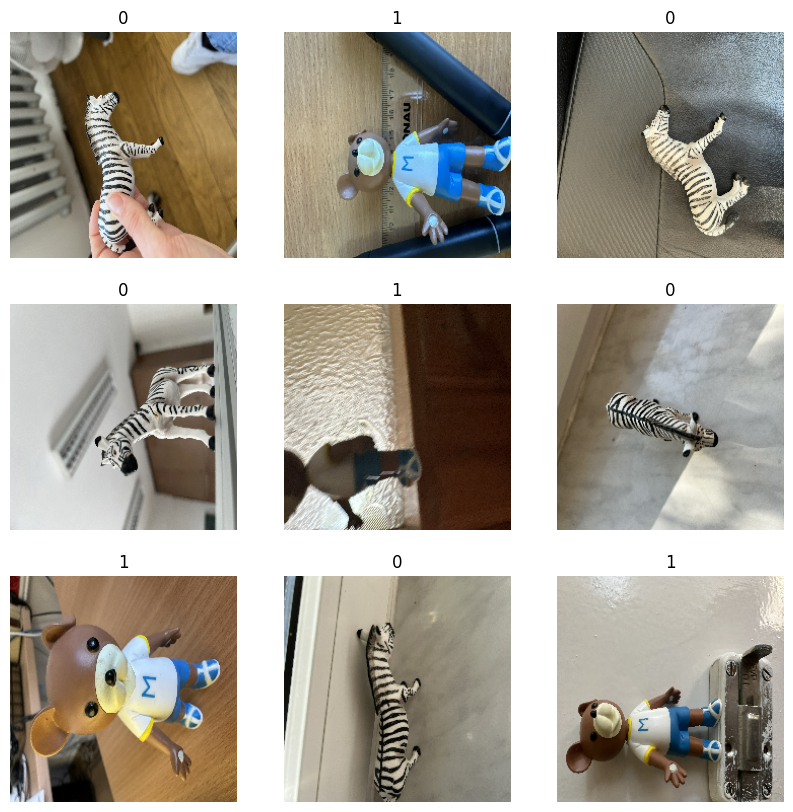

In [12]:
for images, labels in test_ds_E.take(1): 
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy()) 
        plt.axis("off")

In [16]:
# Loss function for binary classification available in the Keras library
loss_function = keras.losses.BinaryCrossentropy(from_logits=True)

# Model compilation and hyperparameter tuning: 

For research purposes, a copy of the base model was made, utilizing MobileNetV2 as the feature extractor, while also incorporating the pre-trained weights.


In [13]:
# Create a copy of the model for each of the optimization algorithms


model_adam_E = tf.keras.models.clone_model(model_final)
model_adam_E.set_weights(model_final.get_weights())
model_gd_I = tf.keras.models.clone_model(model_final)
model_gd_I.set_weights(model_final.get_weights())
model_sgd_I = tf.keras.models.clone_model(model_final)
model_sgd_I.set_weights(model_final.get_weights())
model_momentum_I = tf.keras.models.clone_model(model_final)
model_momentum_I.set_weights(model_final.get_weights())
model_adagard_I = tf.keras.models.clone_model(model_final)
model_adagard_I.set_weights(model_final.get_weights())
model_rmsprop_I = tf.keras.models.clone_model(model_final)
model_rmsprop_I.set_weights(model_final.get_weights())
model_adam_I = tf.keras.models.clone_model(model_final)
model_adam_I.set_weights(model_final.get_weights())
model_gd_E = tf.keras.models.clone_model(model_final)
model_gd_E.set_weights(model_final.get_weights())
model_sgd_E = tf.keras.models.clone_model(model_final)
model_sgd_E.set_weights(model_final.get_weights())
model_momentum_E = tf.keras.models.clone_model(model_final)
model_momentum_E.set_weights(model_final.get_weights())
model_adagard_E = tf.keras.models.clone_model(model_final)
model_adagard_E.set_weights(model_final.get_weights())
model_rmsprop_E = tf.keras.models.clone_model(model_final)
model_rmsprop_E.set_weights(model_final.get_weights())
model_adam_E = tf.keras.models.clone_model(model_final)
model_adam_E.set_weights(model_final.get_weights())

In [14]:
# Using the previously defined optimization algorithms, we create optimizers that will be used during model training

learning_rate = 0.01

optimizer_gd  = create_optimizer('gd', learning_rate)
optimizer_sgd  = create_optimizer('sgd', learning_rate)
optimizer_momentum  = create_optimizer('momentum', learning_rate)
optimizer_adagrad  = create_optimizer('adagrad', learning_rate)
optimizer_rmsprop  = create_optimizer('rmsprop', learning_rate)
optimizer_adam  = create_optimizer('adam', learning_rate)



In [17]:
# Model compilation for the ImageNette dataset

# Gradient Descent
model_gd_I.compile(optimizer=optimizer_gd, loss=loss_function,metrics='accuracy')
# Stochastic Gradient Descent
model_sgd_I.compile(optimizer=optimizer_sgd, loss=loss_function,  metrics='accuracy')
# Momentum
model_momentum_I.compile(optimizer=optimizer_momentum, loss=loss_function,  metrics='accuracy')
# AdaGrad
model_adagard_I.compile(optimizer=optimizer_adagrad, loss=loss_function,  metrics='accuracy')
# RMSprop
model_rmsprop_I.compile(optimizer=optimizer_rmsprop , loss=loss_function,  metrics='accuracy')
# Adam
model_adam_I.compile(optimizer=optimizer_adam, loss=loss_function,  metrics='accuracy')


In [18]:
# Model compilation for the ToyVision dataset

# Gradient Descent
model_gd_E.compile(optimizer=optimizer_gd, loss=loss_function,  metrics='accuracy')
# Stochastic Gradient Descent
model_sgd_E.compile(optimizer=optimizer_sgd, loss=loss_function, metrics='accuracy')
# Momentum
model_momentum_E.compile(optimizer=optimizer_momentum, loss=loss_function, metrics='accuracy')
# AdaGrad
model_adagard_E.compile(optimizer=optimizer_adagrad, loss=loss_function, metrics='accuracy')
# RMSprop
model_rmsprop_E.compile(optimizer=optimizer_rmsprop , loss=loss_function, metrics='accuracy')
# Adam
model_adam_E.compile(optimizer=optimizer_adam, loss=loss_function, metrics='accuracy')





# Training the model for selected optimization methods


In [ ]:
# ImageNette

# Gradient Descent
history_1 = model_gd_I.fit(train_ds_I, epochs=20,validation_data=val_ds_I)
# Stochastic Gradient Descent
history_2 = model_sgd_I.fit(train_ds_I, epochs=20, validation_data=val_ds_I)
# Momentum
history_3 = model_momentum_I.fit(train_ds_I, epochs=20, validation_data=val_ds_I)
# AdaGrad
history_4 = model_adagard_I.fit(train_ds_I, epochs=20, validation_data=val_ds_I)
# RMSprop
history_5 = model_rmsprop_I.fit(train_ds_I, epochs=20, validation_data=val_ds_I)
# Adam
history_6 = model_adam_I.fit(train_ds_I, epochs=20, validation_data=val_ds_I)

# ToyVision

# Gradient Descent
history_7 = model_gd_E.fit(train_ds_E, epochs=20, validation_data=val_ds_E)
# Stochastic Gradient Descent
history_8 = model_sgd_E.fit(train_ds_E, epochs=20, validation_data=val_ds_E)
# Momentum
history_9 = model_momentum_E.fit(train_ds_E, epochs=20, validation_data=val_ds_E)
# AdaGrad
history_10 = model_adagard_E.fit(train_ds_E, epochs=20, validation_data=val_ds_E)
# RMSprop
history_11 = model_rmsprop_E.fit(train_ds_E, epochs=20, validation_data=val_ds_E)
# Adam
history_12 = model_adam_E.fit(train_ds_E, epochs=20, validation_data=val_ds_E)
